In [1]:
# 导入
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix

In [3]:
# 读取数据
# df = pd.read_excel("222.xlsx")
df = pd.read_csv("M101.csv")
df.head()

,日期,时间,生产线编号,物料推送气缸推送状态,物料推送气缸收回状态,物料推送数,物料待抓取数,放置容器数,容器上传检测数,填装检测数,...,不合格数,物料推送装置故障1001,物料检测装置故障2001,填装装置检测故障4001,填装装置定位故障4002,填装装置填装故障4003,加盖装置定位故障5001,加盖装置加盖故障5002,拧盖装置定位故障6001,拧盖装置拧盖故障6002
0,1,0,M101,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,M101,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,M101,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,M101,1,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,M101,0,1,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df = df.drop(['日期','生产线编号'], axis=1)
df.set_index('时间', inplace=True)

In [5]:
df.info()#查看数据列信息,查看数据有没有缺失值

<class 'pandas.core.frame.DataFrame'>
Index: 636509 entries, 0 to 29009
Data columns (total 34 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   物料推送气缸推送状态    636509 non-null  int64
 1   物料推送气缸收回状态    636509 non-null  int64
 2   物料推送数         636509 non-null  int64
 3   物料待抓取数        636509 non-null  int64
 4   放置容器数         636509 non-null  int64
 5   容器上传检测数       636509 non-null  int64
 6   填装检测数         636509 non-null  int64
 7   填装定位器固定状态     636509 non-null  int64
 8   填装定位器放开状态     636509 non-null  int64
 9   物料抓取数         636509 non-null  int64
 10  填装旋转数         636509 non-null  int64
 11  填装下降数         636509 non-null  int64
 12  填装数           636509 non-null  int64
 13  加盖检测数         636509 non-null  int64
 14  加盖定位数         636509 non-null  int64
 15  推盖数           636509 non-null  int64
 16  加盖下降数         636509 non-null  int64
 17  加盖数           636509 non-null  int64
 18  拧盖检测数         636509 non-null  int64
 19  拧盖定位数   

In [6]:
for i in df.columns:
    print(df[i].value_counts())
    print()

物料推送气缸推送状态
0    540148
1     96361
Name: count, dtype: int64

物料推送气缸收回状态
1    545457
0     91052
Name: count, dtype: int64

物料推送数
3447    671
987     651
1623    641
333     590
2904    579
       ... 
4289      2
4291      2
4292      2
4294      2
4295      2
Name: count, Length: 4297, dtype: int64

物料待抓取数
987     651
1623    626
333     590
471     567
2904    564
       ... 
4289      2
4291      2
4292      2
4294      2
4295      2
Name: count, Length: 4296, dtype: int64

放置容器数
104     699
977     693
1185    665
92      644
1101    643
       ... 
1439     20
1440     20
1441     20
1442     20
1443      4
Name: count, Length: 1444, dtype: int64

容器上传检测数
103     699
976     693
1184    665
91      644
1100    643
       ... 
1432     20
1431     20
1430     20
1429     20
1442      3
Name: count, Length: 1443, dtype: int64

填装检测数
258     759
890     731
101     699
110     693
745     692
       ... 
1427     20
1428     20
1429     20
1430     20
1431     14
Name: count, Length

In [7]:
# 计算每列缺失值的数量
missing_values_count = df.isnull().sum()
# 将有缺失值的列名放入一个列表中
miss_columns = df.columns[df.isnull().any()].tolist()
# 输出含有缺失值的列及对应的缺失数量
miss_values_columns= missing_values_count[missing_values_count > 0]
miss_values_columns

Series([], dtype: int64)

## 异常值检测？

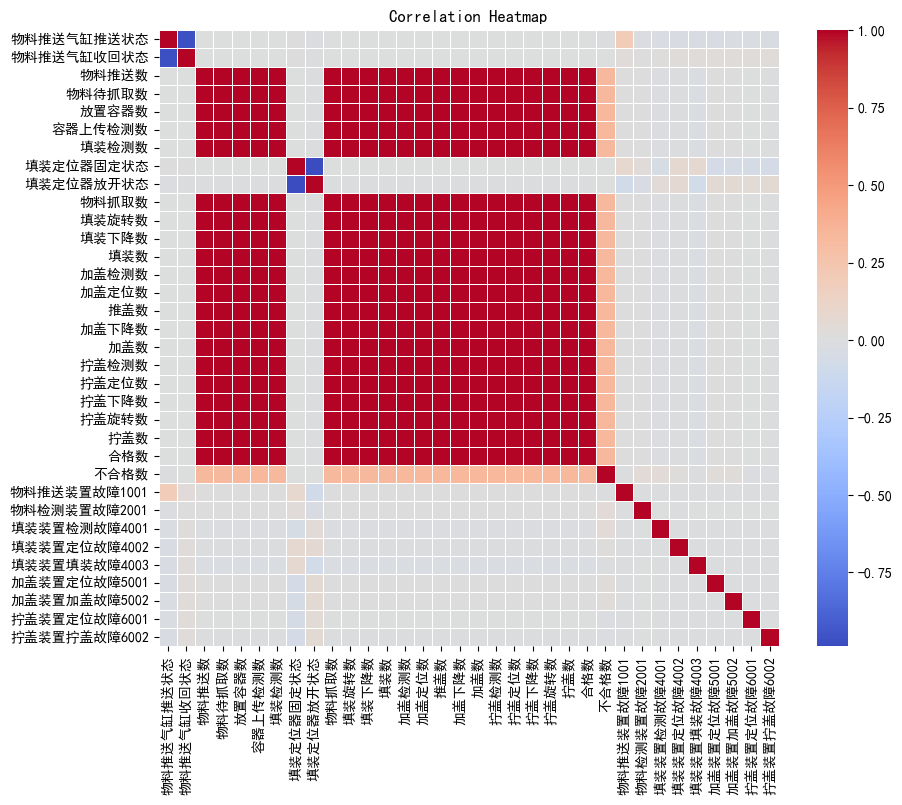

In [8]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


In [9]:
df.columns

Index(['物料推送气缸推送状态', '物料推送气缸收回状态', '物料推送数', '物料待抓取数', '放置容器数', '容器上传检测数',
       '填装检测数', '填装定位器固定状态', '填装定位器放开状态', '物料抓取数', '填装旋转数', '填装下降数', '填装数',
       '加盖检测数', '加盖定位数', '推盖数', '加盖下降数', '加盖数', '拧盖检测数', '拧盖定位数', '拧盖下降数',
       '拧盖旋转数', '拧盖数', '合格数', '不合格数', '物料推送装置故障1001', '物料检测装置故障2001',
       '填装装置检测故障4001', '填装装置定位故障4002', '填装装置填装故障4003', '加盖装置定位故障5001',
       '加盖装置加盖故障5002', '拧盖装置定位故障6001', '拧盖装置拧盖故障6002'],
      dtype='object')

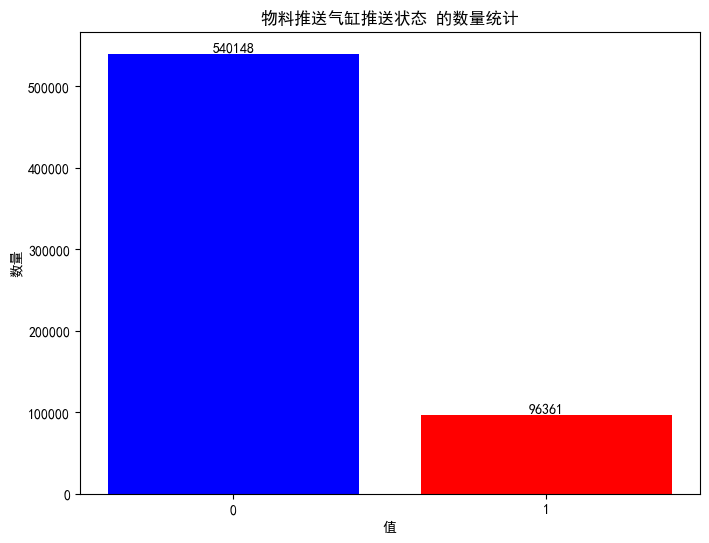

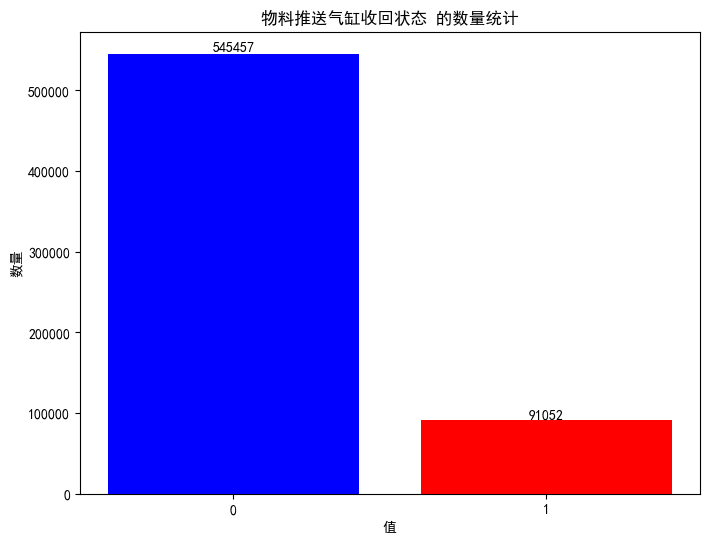

In [10]:
# 特征列表
features_1 = ['物料推送气缸推送状态', '物料推送气缸收回状态']

# 为每个特征绘制柱状图
for feature in features_1:
    # 获取当前特征的计数
    counts = df[feature].value_counts()
    
    # 绘制柱状图
    plt.figure(figsize=(8, 6))
    bars = plt.bar(range(len(counts)), counts, color=['b', 'r'])  # 给柱子上色

    # 在柱子上方添加数量标签
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

    plt.title(f'{feature} 的数量统计')
    plt.xlabel('值')
    plt.ylabel('数量')
    plt.xticks(ticks=range(len(counts)), labels=['0', '1'])  # 设置 x 轴标签
    plt.show()

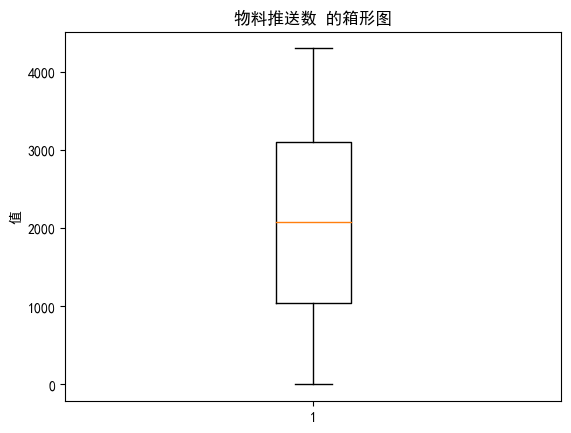

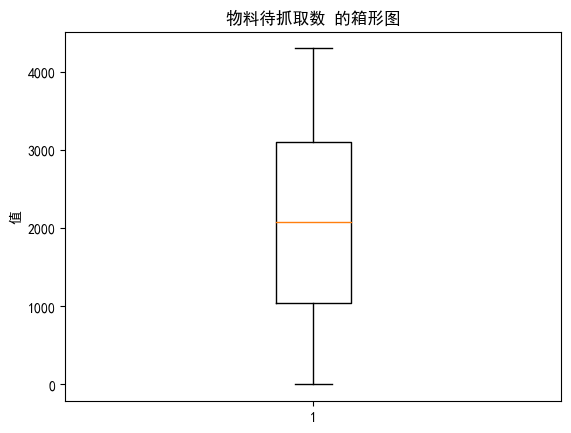

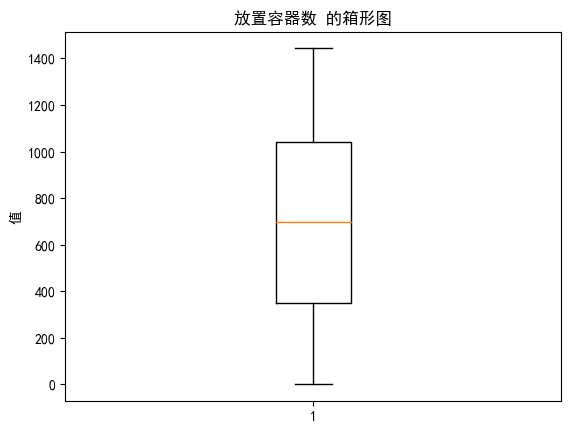

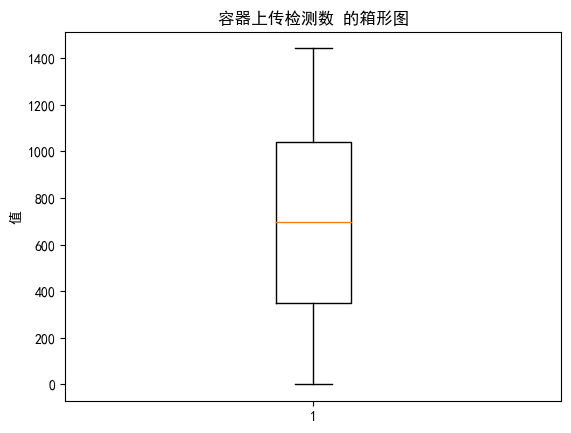

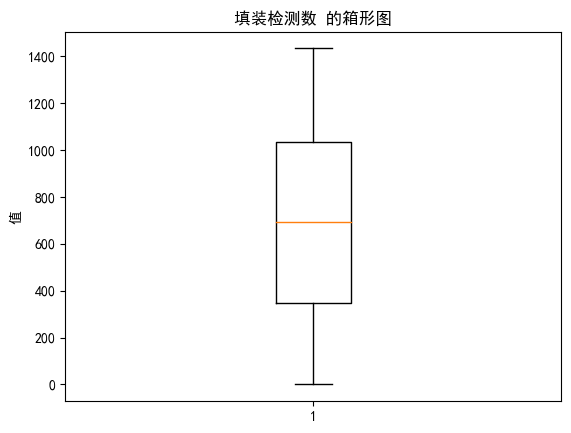

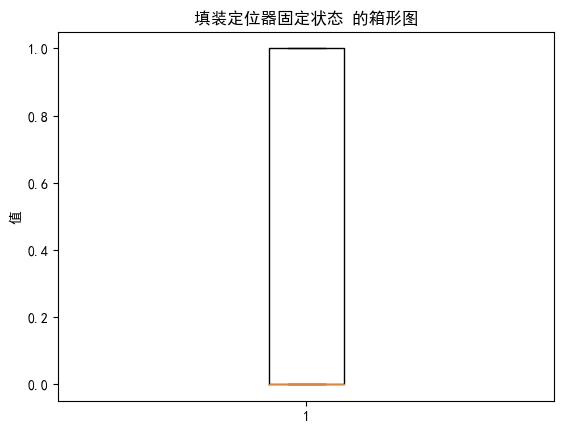

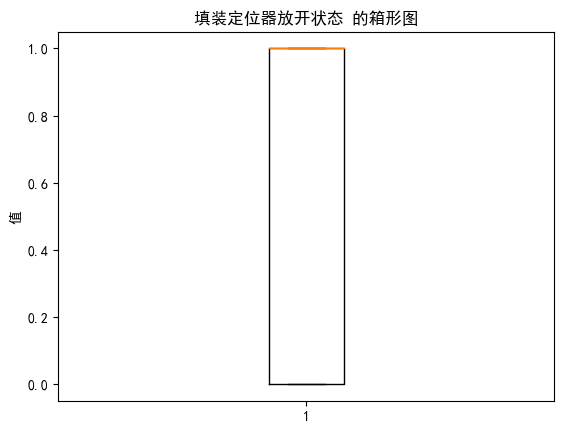

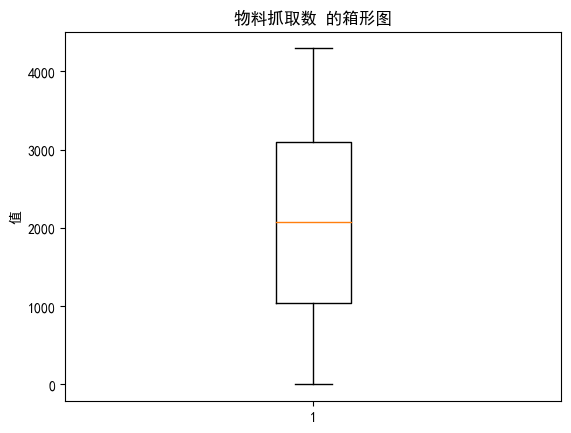

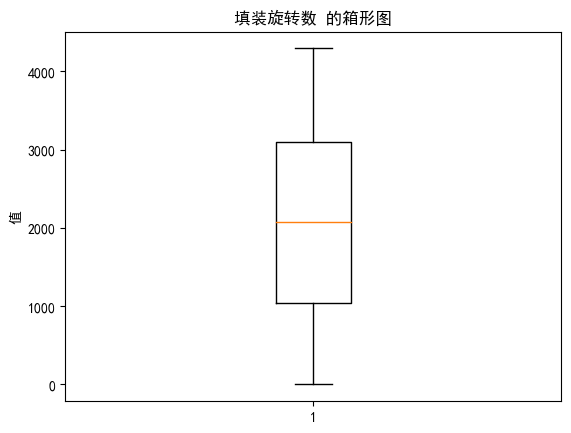

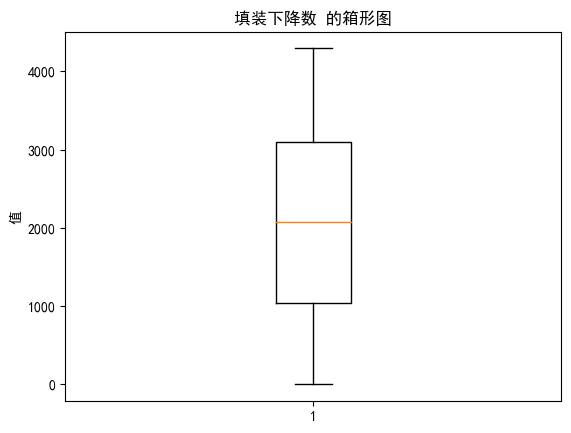

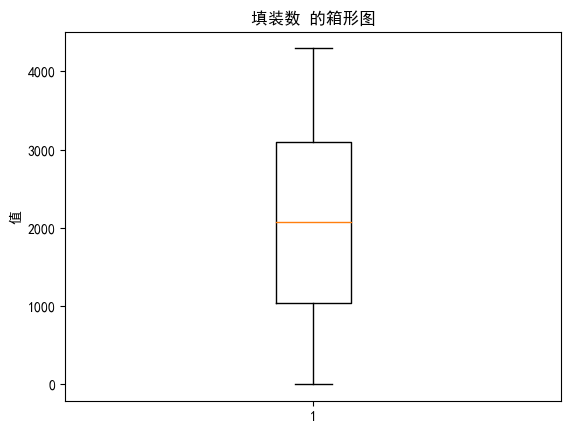

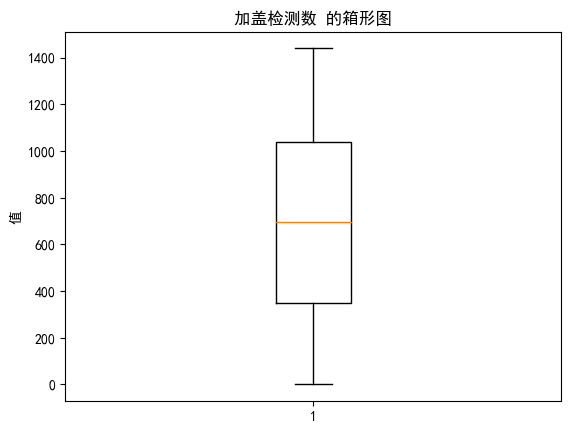

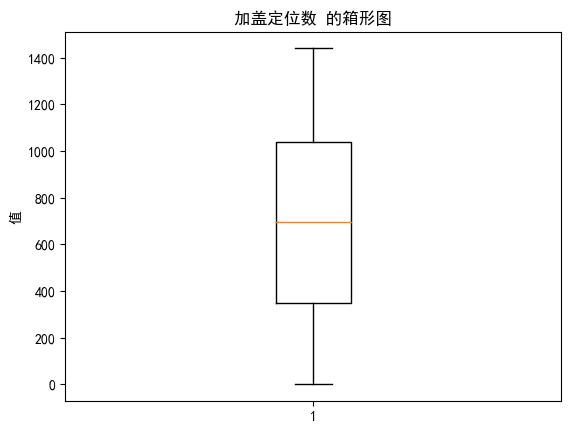

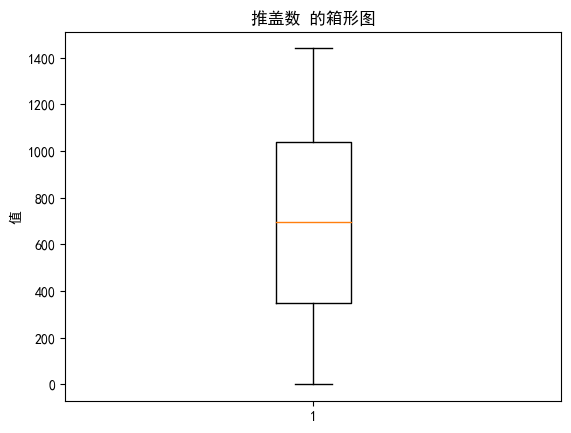

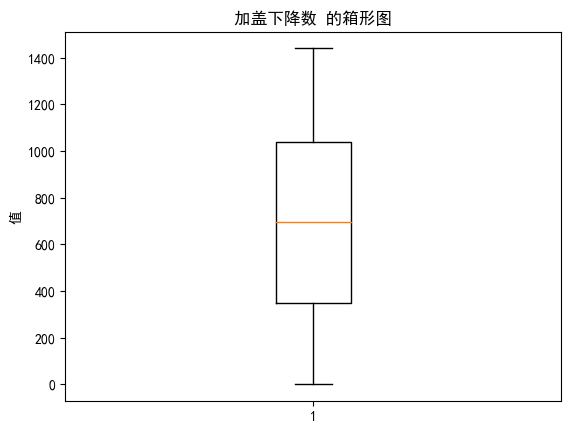

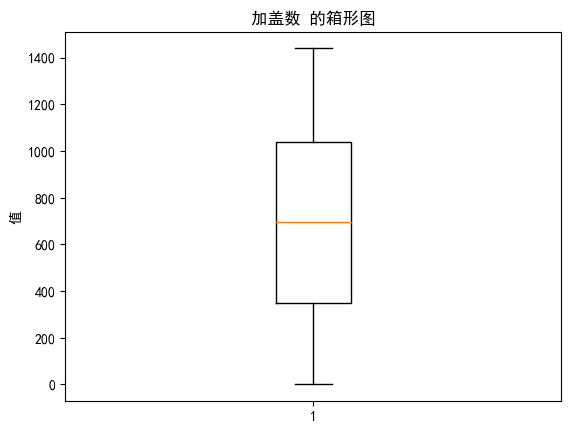

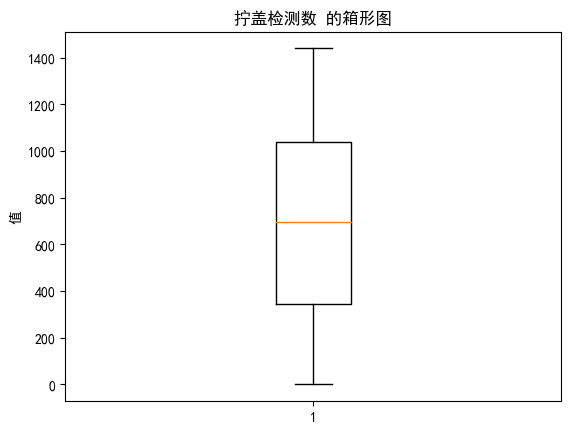

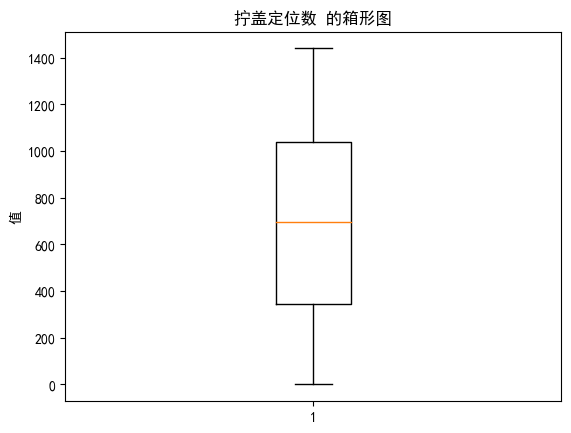

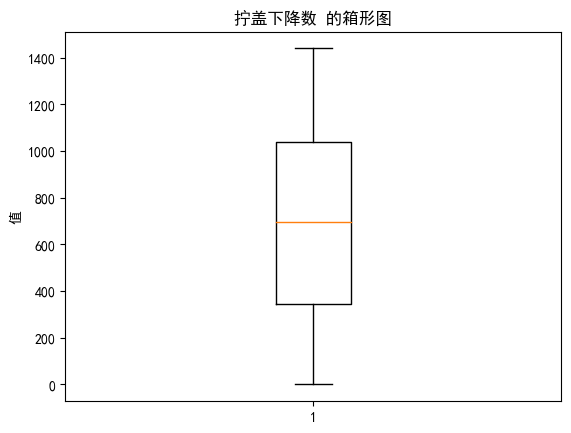

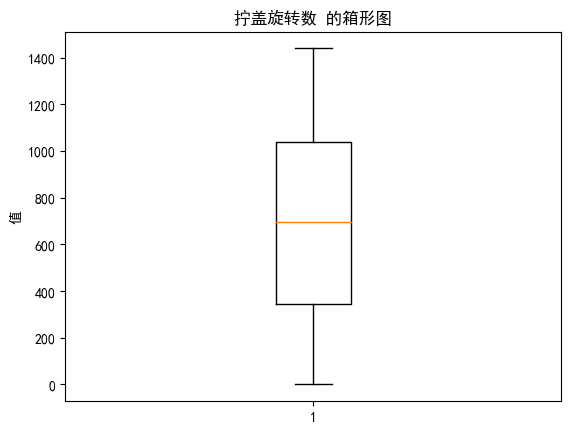

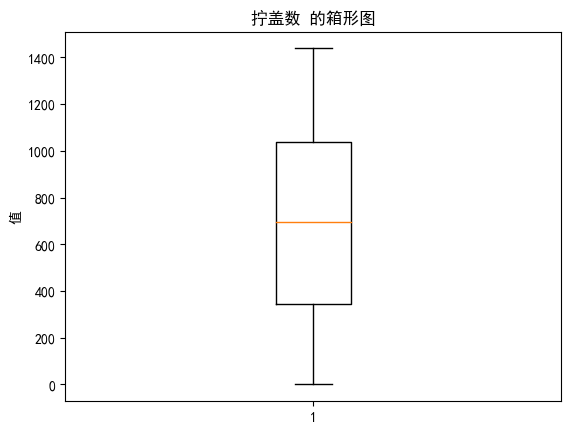

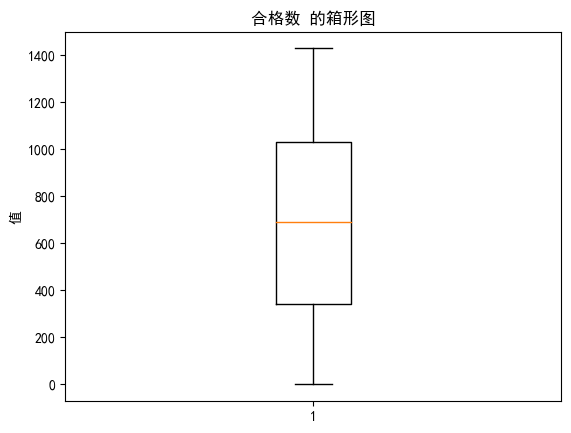

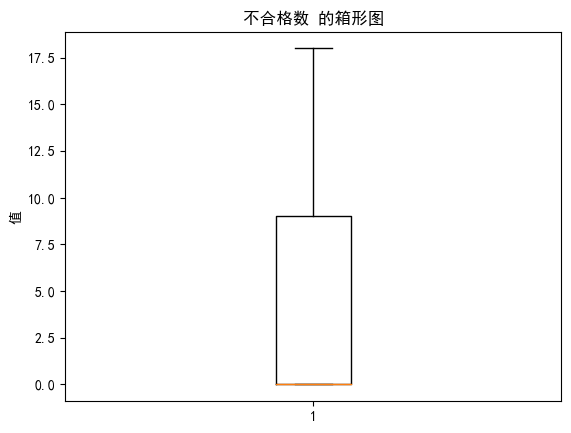

In [11]:
features_2=['物料推送数', '物料待抓取数', '放置容器数', '容器上传检测数',
       '填装检测数', '填装定位器固定状态', '填装定位器放开状态', '物料抓取数', '填装旋转数', '填装下降数', '填装数',
       '加盖检测数', '加盖定位数', '推盖数', '加盖下降数', '加盖数', '拧盖检测数', '拧盖定位数', '拧盖下降数',
       '拧盖旋转数', '拧盖数', '合格数', '不合格数']
# 为每个特征绘制柱状图
for feature in features_2:
    # 绘制箱形图
    plt.figure()
    plt.boxplot(df[feature])
    plt.title(f'{feature} 的箱形图')
    plt.ylabel('值')
    plt.show()


In [12]:
df.describe()

,物料推送气缸推送状态,物料推送气缸收回状态,物料推送数,物料待抓取数,放置容器数,容器上传检测数,填装检测数,填装定位器固定状态,填装定位器放开状态,物料抓取数,...,不合格数,物料推送装置故障1001,物料检测装置故障2001,填装装置检测故障4001,填装装置定位故障4002,填装装置填装故障4003,加盖装置定位故障5001,加盖装置加盖故障5002,拧盖装置定位故障6001,拧盖装置拧盖故障6002
count,636509.000000,636509.000000,636509.000000,636509.000000,636509.000000,636509.000000,636509.000000,636509.000000,636509.000000,636509.000000,...,636509.000000,636509.000000,636509.000000,636509.000000,636509.000000,636509.000000,636509.000000,636509.000000,636509.000000,636509.000000
mean,0.151390,0.856951,2072.799495,2071.977414,696.554430,695.506637,690.301584,0.454853,0.550987,2070.431131,...,3.745281,6.721467,1.584430,9.497919,18.441006,17.055746,19.995860,17.359406,19.129390,25.092060
std,0.358429,0.350123,1195.354527,1195.066290,399.989312,399.989273,398.373923,0.497958,0.497394,1195.115806,...,4.847687,81.749743,56.284448,194.707533,271.036804,260.736190,315.594073,294.160729,338.274617,387.263693
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1038.000000,1038.000000,350.000000,349.000000,346.000000,0.000000,0.000000,1036.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,2076.000000,2076.000000,698.000000,697.000000,691.000000,0.000000,1.000000,2073.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,3103.000000,3102.000000,1041.000000,1040.000000,1034.000000,1.000000,1.000000,3101.000000,...,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,4296.000000,4295.000000,1443.000000,1442.000000,1431.000000,1.000000,1.000000,4293.000000,...,18.000000,1001.000000,2001.000000,4001.000000,4002.000000,4003.000000,5001.000000,5002.000000,6001.000000,6002.000000


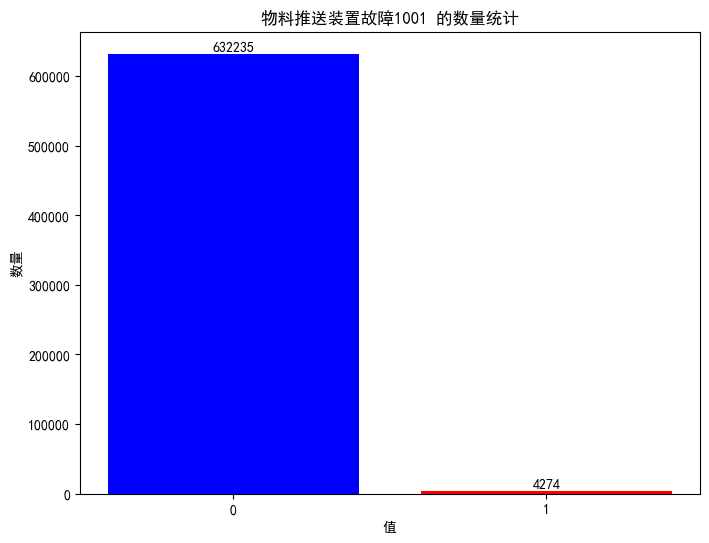

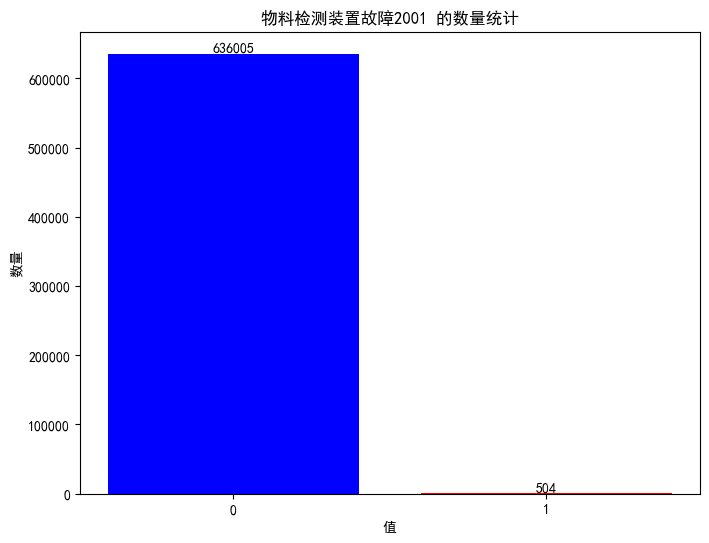

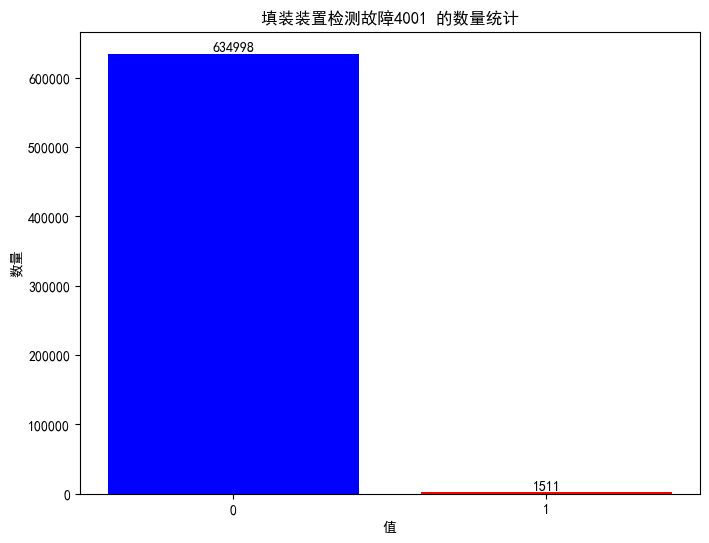

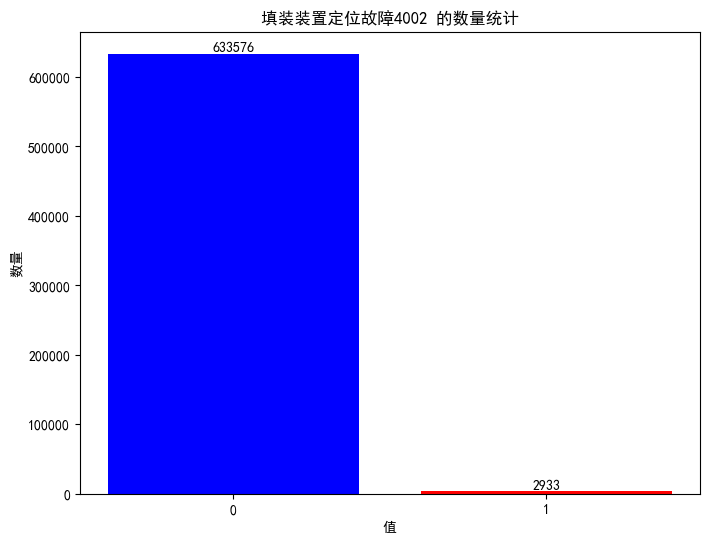

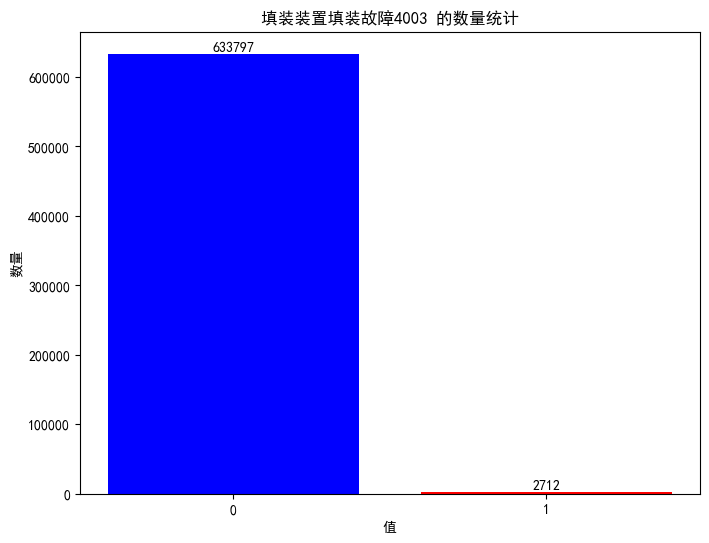

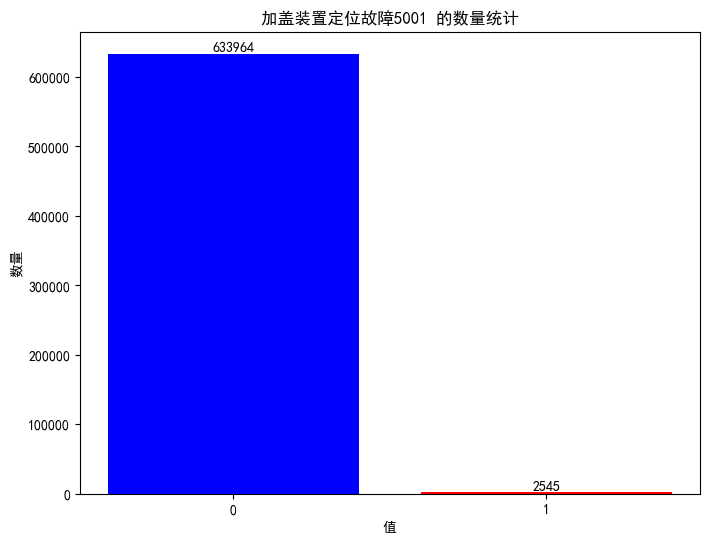

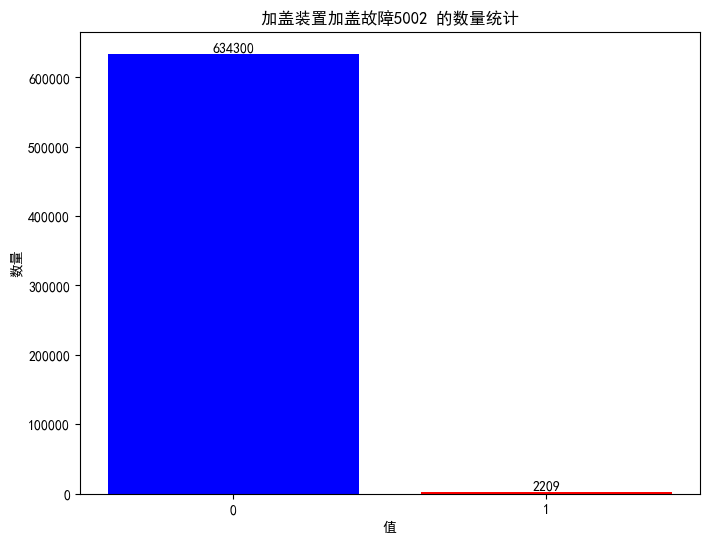

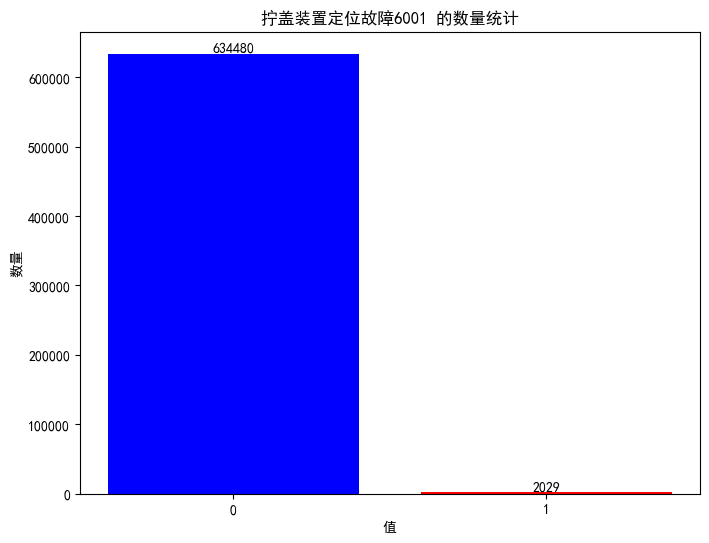

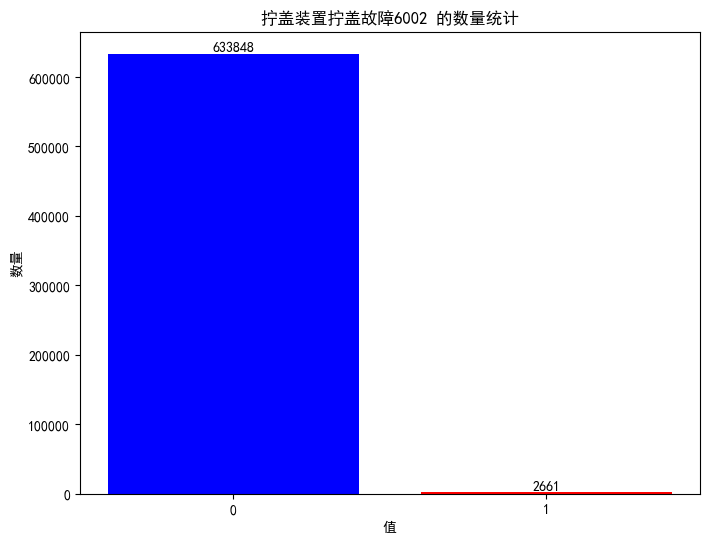

In [14]:
# 特征列表
list_labels=['物料推送装置故障1001', '物料检测装置故障2001',
       '填装装置检测故障4001', '填装装置定位故障4002', '填装装置填装故障4003', '加盖装置定位故障5001',
       '加盖装置加盖故障5002', '拧盖装置定位故障6001', '拧盖装置拧盖故障6002']

# 为每个特征绘制柱状图
for feature in list_labels:
    # 获取当前特征的计数
    counts = df[feature].value_counts()
    
    # 绘制柱状图
    plt.figure(figsize=(8, 6))
    bars = plt.bar(range(len(counts)), counts, color=['b', 'r'])  # 给柱子上色

    # 在柱子上方添加数量标签
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

    plt.title(f'{feature} 的数量统计')
    plt.xlabel('值')
    plt.ylabel('数量')
    plt.xticks(ticks=range(len(counts)), labels=['0', '1'])  # 设置 x 轴标签
    plt.show()

# 建模
过采样或者使用原数据

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 假设df是你的DataFrame，并且已经按时间排序
# 选择输入特征和目标变量
features = df2.drop('error', axis=1)  # 这里假设'合格数'是目标变量
target = df2['error']

# 归一化特征
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# 划分数据窗口
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 5  # 例如，使用5个时间点的数据来预测下一个时间点
X, y = create_dataset(pd.DataFrame(scaled_features), target, time_steps)


In [ ]:
# 使用模型进行预测
y_pred = model2.predict(X)
y_pred = (y_pred > 0.4)  # 根据需要调整阈值

# 计算混淆矩阵
cm = confusion_matrix(y, np.round(y_pred))
print('混淆矩阵：')
print(cm)

# 计算召回率等指标
report = classification_report(y, np.round(y_pred), target_names=['Class 0', 'Class 1'])
print('分类报告：')
print(report)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix
import pandas as pd


X = df.drop(list_labels, axis=1)  # 替换为你数据集中的特征列名
y = df[list_labels]  # 替换为你的标签列名

# 使用MultiLabelBinarizer来转换标签列
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y.values)

# 划分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# 创建决策树分类器实例
classifier = OneVsRestClassifier(DecisionTreeClassifier())

# 训练模型
classifier.fit(X_train, y_train)

# 预测测试集结果
y_pred = classifier.predict(X_test)
# 计算混淆矩阵
confusion_matrix = multilabel_confusion_matrix(y_test, y_pred)

# 打印混淆矩阵
print(confusion_matrix)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'模型准确率: {accuracy:.2f}')

# 将类别标签转换为字符串列表
target_names = [str(cls) for cls in mlb.classes_]

# 计算并打印分类报告
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)


[[[     0      0]
  [     0 127302]]

 [[126455      7]
  [     4    836]]

 [[127198      0]
  [     0    104]]

 [[127005      5]
  [     3    289]]

 [[126666     66]
  [     2    568]]

 [[126581    176]
  [     0    545]]

 [[126743     57]
  [     2    500]]

 [[126768     83]
  [     0    451]]

 [[126820     75]
  [     4    403]]

 [[126658    116]
  [     0    528]]]
模型准确率: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127302
        1001       0.99      1.00      0.99       840
        2001       1.00      1.00      1.00       104
        4001       0.98      0.99      0.99       292
        4002       0.90      1.00      0.94       570
        4003       0.76      1.00      0.86       545
        5001       0.90      1.00      0.94       502
        5002       0.84      1.00      0.92       451
        6001       0.84      0.99      0.91       407
        6002       0.82      1.00      0.90       528

   micro avg